### Fit a Gaussian curve for the combined signal of a BAO-like gaussian, and a Ca H&K-like gaussian

#### Limitations:  
* I created the synthetic BAO fit by 'eyeballing' the ones from the articles, so I wouldn't trust this for more than an OoM estimate, and a general understanding of the way the peak is shifted.
* The peak is shifted even before I add the ISM line, due to (I think) aliasing effects when moving from a 2D grid to angular wedges. Since I only look at the differences (pairs of with/without an ISM line) it shouldn't matter too much.
* The real way to fit the BAO peak is directly on the 2D data, which might behave differently.


In [721]:
import matplotlib.pyplot as plt
from mpl_toolkits import axes_grid1
import numpy as np
import lmfit
%matplotlib inline
%config InlineBackend.figure_format = 'svg' 

from collections import namedtuple

### Functions for converting 2D data to angular wedges

In [722]:
def sin_arccos(mu):
    return np.sqrt(1-mu**2)

def cos_atan2(x,y):
    return y/np.sqrt(np.square(x) + np.square(y))

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = np.average(values, weights=weights)
    variance = np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, np.sqrt(variance))

def get_mu_vector(ar_flux_bins, ar_weight_bins, scale_x, scale_y, mu_start, mu_end, steps):
    ar_vec = np.zeros(steps)
    # for now set upper limit by x axis
    step = ar_flux_bins.shape[0]*float(scale_x)/steps
    ar_radius = np.arange(steps)*step
    ar_stdev = np.zeros_like(ar_vec)
    ar_count = np.zeros_like(ar_vec)
    x,y = np.ogrid[0:ar_flux_bins.shape[0], 0:ar_flux_bins.shape[1]] * np.array([scale_x, scale_y])
    r_sq_pixel = x*x + y*y
    mu_pixel = cos_atan2(y,x) 

    for i in range(1, steps):
        r = ar_radius[i]
        mask_r = np.logical_and(r_sq_pixel >= (r-step)*(r-step), r_sq_pixel < r*r)
        mask_scale = np.logical_and(abs(x - r * mu_pixel) < scale_x,
                                   abs(y - r * sin_arccos(mu_pixel)) <  scale_y)
        mask_mu = np.logical_and(mu_pixel > mu_start, mu_pixel <= mu_end)
        
        ar_flux_pixels = ar_flux_bins[(mask_r | mask_scale) & mask_mu]
        ar_weight_pixels = ar_weight_bins[(mask_r | mask_scale) & mask_mu]
        if ar_weight_pixels.size:
            ar_vec[i], ar_stdev[i] = weighted_avg_and_std(values=ar_flux_pixels, weights=ar_weight_pixels)
        else:
            ar_vec[i] = 0
            ar_stdev[i] = np.inf
        ar_count[i] = ar_weight_pixels.size
    return ar_radius, ar_vec, ar_stdev, ar_count

def calc_mu_ranges(ar_flux, ar_weights, mu_ranges, x_max, y_max, steps=50):
    r_min, r_max = (0.2, 0.9)
    graph_x_start = r_min*x_max
    graph_x_end =   r_max*x_max
    x_list = []
    y_list = []
    delta_y_list = []
    scale_x = x_max / ar_flux.shape[0]
    scale_y = x_max / ar_flux.shape[1]
    
    with np.errstate(divide='ignore', invalid='ignore'):
        for mu_min, mu_max in mu_ranges:
            ar_radius, xi_r_mu_vector, xi_r_mu_stdev, xi_r_mu_count = get_mu_vector(
                ar_flux, ar_weights, scale_x, scale_y, mu_min, mu_max, steps)
            ar_radius_range_mask = [np.logical_and(graph_x_start<=ar_radius, ar_radius<=graph_x_end)] 
            x = ar_radius[ar_radius_range_mask]
            y = xi_r_mu_vector[ar_radius_range_mask]*np.square(x)
            delta_y = xi_r_mu_stdev[ar_radius_range_mask]*np.square(x)#/np.sqrt(xi_r_mu_count[ar_radius_range_mask]
            x_list += [x]
            y_list += [y]
            delta_y_list += [delta_y]
    return x_list, y_list, delta_y_list

def plot_mu_ranges(x_list, y_list, delta_y_list, mu_ranges, ylim):
    r_min, r_max = (0.2, 0.9)
    colors = ('b','g','r','c')
    for (mu_min, mu_max), x, y, delta_y, c in zip(mu_ranges, x_list, y_list, delta_y_list, colors):
        plt.fill_between(x, y-delta_y, y+delta_y, alpha=0.05, color=c)
        plt.plot(x, y, label=str(mu_min) + r"$<\mu<$" + str(mu_max), color=c)
    plt.xlabel(r"$r[h^{-1}\,{\rmMpc}]$")
    plt.ylabel(r"$r^2\xi(r, \mu)$")
    plt.ylim(ylim)
    plt.legend(loc='best').get_frame().set_linewidth(0.7)

def add_colorbar(im, aspect=20, pad_fraction=0.5, ax1=None, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    aspect = 1./aspect if aspect else None
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca() if not ax1 else ax1
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

The Gaussian fit function takes 3 parameters:
* center along the $x$-axis
* peak height
* width in standard deviations

and additional 2 for the background signal:
* an offset along the $y$-axis
* an arbitrary slope 

In [723]:
params = lmfit.Parameters()
params.add('x_offset', 100., min=40, max=180)
params.add('height', 0.5, min=0.001, max=10)
params.add('width', 20, min=10, max=50)
params.add('y_offset', 0., min=-0.5, max=0.5)
params.add('slope', 0, min=-1e-4, max=1e-4)

In [724]:
def fit_function(params, data, x):
    v = params.valuesdict()
    y = np.exp(- ((x - v['x_offset'])/v['width'])**2)*v['height'] + v['y_offset'] + v['slope']*x
    diff = y - data
    return diff

Set up fixed values and create a BAO-like signal:

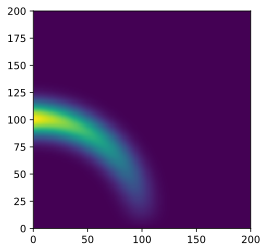

In [725]:
x_grid = np.linspace(0,200,200,endpoint=False)
y_grid = np.linspace(0,200,200,endpoint=False)[:,np.newaxis]
r = np.sqrt(x_grid**2 + y_grid**2)
ang = np.arctan2(y_grid, x_grid)
mu = 1./(1.+(x_grid/200)**2)
# TODO: find the actual width
# NOTE: the 'mu' based powerlaw is just a guess
z = np.exp(-((r-100)/15)**2)*ang*2/np.pi
# relative amplitude of the ISM line
relative_amplitude = 1./20
# The ISM line width is 1-2 pixels wide which is roughly a sigma of 4 Mpc 
# (compared with about 20 Mpc for the BAO signal width)
width = 4.
plt.imshow(z, origin='lower', extent=[0,200,0,200])
plt.show()

### An example line at $40 h^{-1} \text{Mpc}$

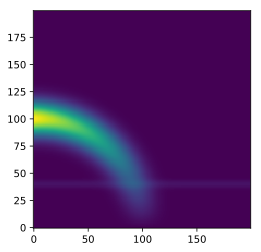

In [726]:
displacement = 40
z_pert = np.exp(-((y_grid-displacement)/width)**2)*relative_amplitude
plt.imshow(z_pert+z, origin='lower')
plt.show()

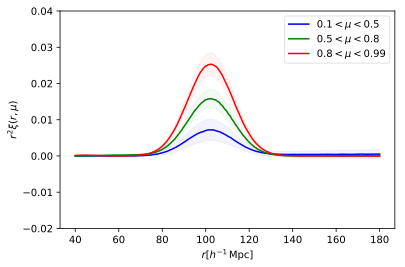

In [727]:
mu_ranges = [(0.1, 0.5), (0.5, 0.8), (0.8, 0.99)]
x_list, y_list, delta_y_list = calc_mu_ranges(
    (z+z_pert)/3.0e5, np.ones_like(z), mu_ranges, x_max=200, y_max=200, steps=400)
plot_mu_ranges(x_list, y_list, delta_y_list, mu_ranges, (-2e-2,4e-2))
plt.show()

In [709]:
# The default LM method did not work well here:
# for x,y in zip(x_list,y_list):
wedge_number = 2
x,y = x_list[wedge_number], y_list[wedge_number]
fit_result = lmfit.minimize(fit_function, params, method='least_squares', 
                            kws={'data': y, 'x': x})

In [710]:
fit_result.params

Parameters([('x_offset',
             <Parameter 'x_offset', 102.22482021249847, bounds=[40:180]>),
            ('height',
             <Parameter 'height', 0.025314702802077444, bounds=[0.001:10]>),
            ('width', <Parameter 'width', 14.834037974998367, bounds=[10:50]>),
            ('y_offset',
             <Parameter 'y_offset', 0.00010770450139077881, bounds=[-0.5:0.5]>),
            ('slope',
             <Parameter 'slope', -7.0046531939783146e-07, bounds=[-0.0001:0.0001]>)])

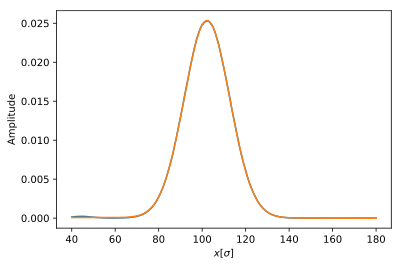

In [728]:
plt.plot(x_list[wedge_number],y_list[wedge_number])
plt.plot(x,fit_function(fit_result.params, x*0, x))
plt.xlabel('$x[\sigma]$')
plt.ylabel('Amplitude')
plt.show()

### Plot the apparent displacement of the BAO signal vs. the 'ISM line' displacement
* This takes some time to generate

In [731]:
def do_fit(z, mu_ranges):
    fit_results = []
    wedge_list = range(len(mu_ranges))
    x_list, y_list, delta_y_list = calc_mu_ranges(
        z/4.0e5, np.ones_like(z), mu_ranges, x_max=200, y_max=200, steps=400)
    for wedge_number in wedge_list:
        x = x_list[wedge_number]
        y = y_list[wedge_number]
        fit_results += [lmfit.minimize(fit_function, params, method='least_squares', kws={'data': y, 'x': x})]
    print('.', end='')
    return fit_results
    
baseline_fit = do_fit(z, mu_ranges)

displacement_range = range(40,180,5)
fit_data = []
for j, displacement in enumerate(displacement_range):
    z_pert = np.exp(-((y_grid-displacement)/width)**2)*relative_amplitude
    fit_data += [do_fit(z + z_pert, mu_ranges)]

.............................

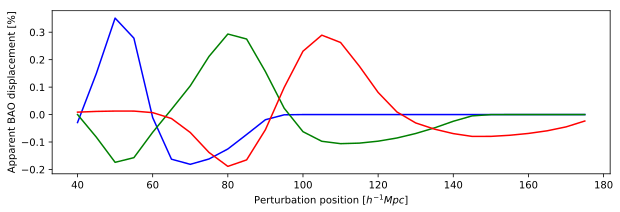

In [738]:
baseline_centers = np.array([w.params.valuesdict()['x_offset'] for w in baseline_fit])
centers = np.array([[w.params.valuesdict()['x_offset'] for w in d] for d in fit_data])
diffs = (centers - baseline_centers) / baseline_centers
plt.figure(figsize=(10,3))
colors = ('b','g','r','c')
for i,c in zip(range(len(mu_ranges)), colors):
    plt.plot(displacement_range, diffs[:,i]*100, color=c)
plt.xlabel(r'Perturbation position $[h^{-1}Mpc]$')
plt.ylabel(r'Apparent BAO displacement [%]')
plt.show()